In [2]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import *
from invariance_functions import *
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [12]:
man = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 150
max_v = 30
n_train = 5
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_pendulum_data(time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[  21.50572622  119.28374568   44.6160355  -103.34811881 -112.25925823]
[ -8.36290744 -25.4422866  -15.86857264 -21.63908938 -29.23291268]


moi:400.05
known: 407.19
learnt: 404.75
[[-6.27994076e-06]
 [-9.99354744e-01]]
[[ 3.55329797e-07]
 [-6.97961319e-01]
 [ 2.61755458e-02]
 [ 6.45507075e-02]]
known: 430.64
learnt: 404.57
[[-0.0242713]
 [ 0.1400032]]
[[-0.02120433]
 [ 0.11814235]
 [-0.00027873]
 [-0.01176183]]


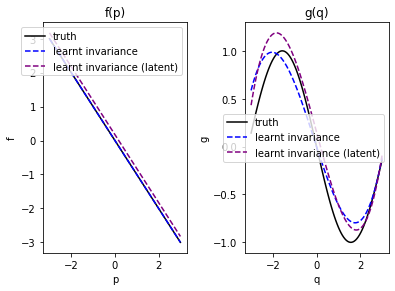

In [13]:

moi, *dump = get_GPR_model(get_MOI(), mean, data, 500)
print("moi:"+format(moi.log_marginal_likelihood().numpy(),".2f"))
jitter = 1e-4
invar_density = 40
invar_range = 3
poly_f_d = 2
poly_g_d = 4
known_kernel = get_invariance_kernel(PendulumInvariance, invar_range, invar_density, jitter) #switch
known, *dump = get_GPR_model(known_kernel, mean,data, 500)
print("known: "+format(known.log_marginal_likelihood().numpy(),".2f"))
learnt_kernel = get_parameterised_invariance_kernel(PolynomialInvariance, invar_range, invar_density, jitter, poly_f_d, poly_g_d) #switch
model, fs, gs, coeff = get_GPR_model(learnt_kernel, mean, data, 3000, stored=True)
print("learnt: "+ format(model.log_marginal_likelihood().numpy(),".2f"))
print(learnt_kernel.f_poly.numpy())
print(learnt_kernel.g_poly.numpy())

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-3,3,100)
multiplier = -learnt_kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -x, label='truth', color="black")
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, -np.sin(x), color="black", label='truth')
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)



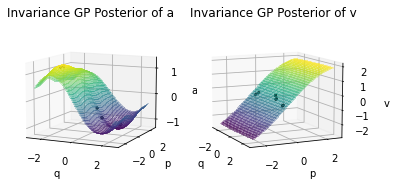

In [20]:
import matplotlib.pyplot as plt
test_range = np.radians(150)
test_density = 40
test_xs = tf.linspace(-test_range,test_range,test_density)
test_vs = tf.linspace(-test_range,test_range,test_density)
test_xx, test_vv = tf.meshgrid(test_xs, test_vs)
test_points = tf.stack([tf.reshape(test_xx,[-1]), tf.reshape(test_vv,[-1])], axis=1)
pred, var = known.predict_f(test_points) ######switch
X, Y = data
pred_a = pred[:int(pred.shape[0]/2),:]
var_a = var[:int(var.shape[0]/2),:]
pred_v = pred[int(pred.shape[0]/2):,:]
var_v = var[int(var.shape[0]/2):,:]
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.3)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax1.plot_surface(test_xx, test_vv, tf.reshape(pred_a, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_a, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax1.scatter(X[:,0], X[:,1],Y[:,1,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax1.view_init(10,-65)
ax1.set_xlabel("q")
ax1.set_ylabel("p")
ax1.set_zlabel("a") 
ax1.set_title("Invariance GP Posterior of a")

ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape), cmap="viridis",linewidth=0, antialiased=False, alpha=0.3)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)+1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
#ax2.plot_surface(test_xx, test_vv, tf.reshape(pred_v, test_xx.shape)-1.96*tf.math.sqrt(tf.reshape(var_v, test_xx.shape)), color="grey",linewidth=0, antialiased=False, alpha=0.4)
ax2.scatter(X[:,0], X[:,1],Y[:,0,None], color="black", marker="o", s=3) #switch for velocity acceleration
ax2.view_init(10,-25)
ax2.set_xlabel("q")
ax2.set_ylabel("p")
ax2.set_zlabel("v") 
ax2.set_title("Invariance GP Posterior of v")
plt.savefig("figures/posterior_pendulum_invariance.pdf")

0
148.99611255027315
19.7997287021386
0.0026325085199132513
0.0006831552163419867
0.0002161915760245619
0.00030892150736275167
0.00017449664121894614


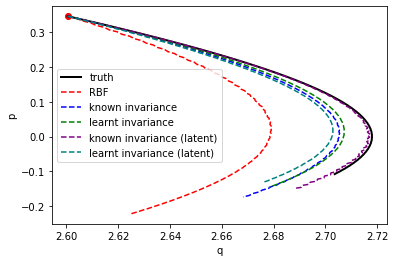

MSE & 0.0026 & 0.0007 & 0.0002 & 0.0003 & 0.0002 \\
1
34.40011291748203
19.605121485972248
0.0007457792611483838
0.0006235290194647662
0.0005246333919188725
0.0006704331236524161
0.0006767881314376388


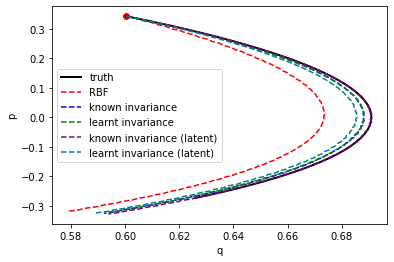

MSE & 0.0017 & 0.0007 & 0.0004 & 0.0005 & 0.0004 \\
2
19.976755089502603
-24.876803201837312
0.0005568425929976444
0.0005888706299240149
0.0005342925634681064
0.0005052414342836371


In [26]:


eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []
eva_future_inv_l = []
eva_future_inv_lp = []

dynamics = pendulum_dynamics

# pendulum
def energy(X):
    return 0.5*tf.square(X[:,1])-np.cos(X[:,0])

for i in range(10):
    print(i)
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))

    print(np.degrees(test_starting_position))
    print(np.degrees(test_starting_velocity))
    test_starting = (test_starting_position, test_starting_velocity)
    time_setting = (testing_time, time_step)

    evaluate_moi = evaluate_model_future(moi, test_starting, dynamics,time_setting, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])

    evaluate_invariance =evaluate_model_future(known, test_starting, dynamics,time_setting, energy)
    eva_future_inv.append(evaluate_invariance[0])
    print(evaluate_invariance[0])

    evaluate_invariance_p =evaluate_model_future(model, test_starting, dynamics, time_setting, energy)#, (m.kernel.inv_f, m.kernel.inv_g), (lambda x: x, lambda x:np.sin(x)))
    eva_future_inv_p.append(evaluate_invariance_p[0])
    print(evaluate_invariance_p[0])


    fig, ax = plt.subplots()
    plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
    plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
    plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
    plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
    plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
    plt.xlabel("q")
    plt.ylabel("p")
    plt.legend()
    plt.show()
    print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+" & "+format((np.mean(eva_future_inv_l)),".4f")+" & "+format((np.mean(eva_future_inv_lp)),".4f")+ ' \\\\')



In [106]:
print("Log Marginal Likelihood & " + format((moi.log_marginal_likelihood().numpy()),".2f")+" & "+ format((known.log_marginal_likelihood().numpy()),".2f") + " & "+ format((model.log_marginal_likelihood().numpy()),".2f") +" & "+ format((known_latent.log_marginal_likelihood().numpy()),".2f") + " & "+ format((model_latent.log_marginal_likelihood().numpy()),".2f")+ ' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format((np.mean(eva_future_inv_p)),".4f")+" & "+format((np.mean(eva_future_inv_l)),".4f")+" & "+format((np.mean(eva_future_inv_lp)),".4f")+ ' \\\\')

Log Marginal Likelihood & 40.50 & 46.74 & 50.20 & 64.29 & 56.53 \\
MSE & 0.0233 & 0.0334 & 0.0266 & 0.0308 & 0.0291 \\


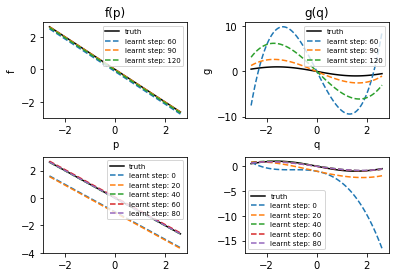

In [19]:

import matplotlib.pyplot as plt
from numpy.polynomial import polynomial
x = np.linspace(-np.radians(150),np.radians(150),100)
fig, (axs) = plt.subplots(1, 2)
axs[0].plot(x, -x, label='truth', color="black")
axs[0].plot(x, -np.sin(x), color="black", label='truth')
axs[1].plot(x, -x, label='truth', color="black")
axs[1].plot(x, -np.sin(x), color="black", label='truth')
axs[0].set_title("f(p)")
axs[0].set_xlabel("p")
axs[0].set_ylabel("f")
axs[1].set_title("g(q)")
axs[1].set_xlabel("q")
axs[1].set_ylabel("g")
for i, (f, g) in enumerate(zip(fs, gs)):
    if i%3==0 and i>3:
        multiplier = -learnt_kernel.f_poly.transform(f[1])
        f = polynomial.Polynomial(np.squeeze(learnt_kernel.f_poly.transform(f)))
        g = polynomial.Polynomial(np.squeeze(learnt_kernel.g_poly.transform(g)))
        axs[0][0].plot(x, f(x)/multiplier, "--", label='learnt step: '+str(i*10))
        axs[0][1].plot(x, g(x)/multiplier, "--", label='learnt step: '+ str(i*10))
axs[0][0].legend(loc=1, prop={"size":7})
axs[0][1].legend(loc=1, prop={"size":7})
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
#plt.savefig("figures/pendulum_learnt_over_time.pdf")



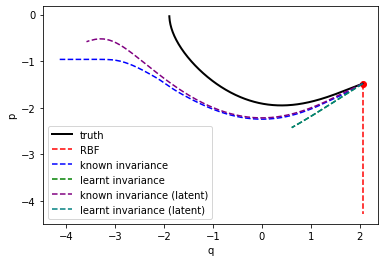

In [8]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.plot(evaluate_invariance_l[1][:,0],evaluate_invariance_l[1][:,1], "--", label="known invariance (latent)", color="purple")
plt.plot(evaluate_invariance_lp[1][:,0],evaluate_invariance_lp[1][:,1], "--", label="learnt invariance (latent)", color="teal")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
plt.savefig("figures/pendulum_predicted.pdf")

Text(0, 0.5, 'E')

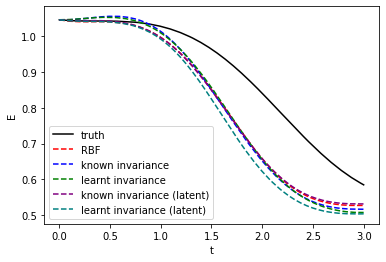

In [26]:
t = np.linspace(0, testing_time, int(testing_time/time_step))
plt.plot(t, tf.squeeze(evaluate_invariance[5])+1, label="truth", color="black")
plt.plot(t, tf.squeeze(evaluate_moi[6])+1, "--", label="RBF", color="red")
plt.plot(t, tf.squeeze(evaluate_invariance[6])+1,"--" ,  label="known invariance", color="blue")
plt.plot(t, tf.squeeze(evaluate_invariance_p[6])+1, "--",label="learnt invariance", color="green")
plt.plot(t, tf.squeeze(evaluate_invariance_l[6])+1,"--" ,  label="known invariance (latent)", color="purple")
plt.plot(t, tf.squeeze(evaluate_invariance_lp[6])+1, "--",label="learnt invariance (latent)", color="teal")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
plt.savefig("figures/pendulum_energy.pdf")

In [ ]:

import importlib, sys
importlib.reload(sys.modules["invariance_functions"])
from invariance_functions import evaluate_model_future

In [ ]:

lmls = np.zeros(5)
future = np.zeros((3,5))
dofs = np.zeros(5)
energies = np.zeros((3,5))
moi = get_GPR_model(get_MOI(), mean, data, 500)
lmls[0]=(moi.log_marginal_likelihood().numpy())
dofs[0] = degree_of_freedom(moi.kernel, np.radians(150),40,moi.likelihood.variance.numpy())
invar_density=20
for i in range(3):
    test_starting_position = np.radians(np.random.uniform(-max_x, max_x))
    test_starting_velocity = np.radians(np.random.uniform(-max_v, max_v))
    test_starting = (test_starting_position, test_starting_velocity)
    for j, jitter in enumerate([7e-6, 1e-5, 5e-5, 9e-5]):
        print(invar_density)
        try:
            kernel = get_pendulum_invariance(np.radians(150), invar_density, jitter) #switch
            m = get_GPR_model(kernel, mean, data, 500)
        except tf.errors.InvalidArgumentError:
            print("jitter too small")
            break 
        lmls[j+1]=(m.log_marginal_likelihood().numpy())
        dofs[j+1] = degree_of_freedom(m.kernel, np.radians(150),40,m.likelihood.variance.numpy())
        print(m.log_marginal_likelihood().numpy())

    #        print(test_starting_position)
    #        print(test_starting_velocity)

        evaluate_moi = evaluate_model_future(moi, test_starting, dynamics, time_setting, energy)

        future[i,0]=(evaluate_moi[0])
        energies[i,0]=abs((evaluate_moi[6][-1]-evaluate_moi[6][0])/evaluate_moi[6][0])

        evaluate_invariance = evaluate_model_future(m, test_starting, dynamics, time_setting, energy)
        print(format(evaluate_invariance[0],".4f"))
        future[i,j+1] = (evaluate_invariance[0])
        energies[i,j+1]=abs((evaluate_invariance[6][-1]-evaluate_invariance[6][0])/evaluate_invariance[6][0])



In [ ]:

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
invs =[1e-5, 1e-4, 1e-3, 1e-2]
axs[0][0].plot(invs, lmls[1:5])
#axs[0][0].plot(invs, np.ones(4)*lml_inv[0],'--', color="black")
axs[0][0].set_ylabel("log marginal likelihood")
axs[0][0].set_xlabel("jitter")
axs[0][0].set_xscale('log')
axs[0][1].plot(invs, np.mean(future[:,1:5],0))
#axs[0][1].plot(invs, np.ones(4)*np.mean(future_inv[:,0],0),'--', color="black")
axs[0][1].set_ylabel("MSE")
axs[0][1].set_xlabel("jitter")
axs[0][1].set_xscale('log')
axs[1][0].plot(invs, abs(np.mean(energies[:,1:5],0)))
#axs[1][0].plot(invs, np.ones(4)*grid_inv[0],'--', color="black")
axs[1][0].set_xlabel("jitter")
axs[1][0].set_ylabel("Energy change(%)")
axs[1][0].set_xscale('log')
axs[1][1].plot(invs, dofs[1:5])
#axs[1][1].plot(invs, np.ones(4)*dofs[0],'--', color="black")
axs[1][1].set_ylabel("degree of freedom")
axs[1][1].set_xlabel("jitter")
axs[1][1].set_xscale('log')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/vary_jitter.pdf")